In [1]:
from gurobipy import *

## 本研究

In [2]:
from asyncio.constants import SENDFILE_FALLBACK_READBUFFER_SIZE
import random
from random import seed
import numpy as np
from scipy.stats import multivariate_normal
class CuttingPlaneAlgorithm:
    def __init__(self,ship_num,stack_num,height,n_init,size,size_,beta,mean,cov,OC,zk,aaa):
        self.ship_num=ship_num
        self.stack_num=stack_num
        self.height=height
        self.n_init=n_init
        self.beta=beta
        self.size=size
        self.size_=size_
        self.mean=mean
        self.cov=cov
        self.OC=OC
        self.zk=zk
        self.O1=[i+1 for i in range(self.ship_num)]
        self.S=[i+1 for i in range(self.stack_num)]
        self.H=[i+1 for i in range(self.height)]
        self.P=[i+1 for i in range(self.ship_num)]
        self.f=stack_num*height-sum(self.n_init)
        self.aaa=aaa

        # 期待値と分散共分散行列の準備
        data_1 = np.random.multivariate_normal(mean, cov, size=self.size)

        O_=np.argsort(data_1)
        O_=O_+np.ones((size,ship_num)).astype(int)
        global O
        self.O=O_.tolist()
        O=self.O

    def get_penalty(self,result):
        self.result=result
        self.penalty=[]
        for k in self.O:
            OO=k
            a=0
            for j in range(self.stack_num):
                for i in range(1,self.height):
                    for i_ in range(i+1,self.height+1):
                        if self.result[i-1][j]!=0 and self.result[i_-1][j]!=0:
                            if OO.index(self.result[i-1][j])>OO.index(self.result[i_-1][j]):
                                # print(j+1,height-i+1,O)
                                a+=1
                                # print("penalty!")
                                    # print(i,i_,j+1,O)
                                break
            self.penalty.append(a)
        self.zk=[i for i, x in enumerate(self.penalty) if x-self.alpha_tmp>0]
        self.OC=[]
        for zk_ in self.zk:
            # if not zk_ in self.aaa:
                # self.aaa.append(zk_)
            self.OC.append(O[zk_])
        return (self.zk,self.OC,self.penalty)

    def solve(self):
        def add_cutting_plane(model,where):
            if where == GRB.callback.MIPSOL:
                c_var,x_var,x_tmp,d_var={},{},{},{}
                for var in self.model._vars:
                    if "u" in var.VarName:
                        u_var=var
                    if "alpha" in var.VarName:
                        alpha_var=var
                        self.alpha_tmp=model.cbGetSolution(var)
                    if "c_" in var.VarName:
                        s=int(var.VarName.split("_")[-3])
                        h=int(var.VarName.split("_")[-2])
                        i=int(var.VarName.split("_")[-1])
                        c_var[s,h,i]=var
                    if "d_" in var.VarName:
                        i=int(var.VarName.split("_")[-1])
                        d_var[i]=var
                    if "x_" in var.VarName:
                        s=int(var.VarName.split("_")[-3])
                        h=int(var.VarName.split("_")[-2])
                        p=int(var.VarName.split("_")[-1])
                        x_var[s,h,p]=var
                        x_tmp[s,h,p]=model.cbGetSolution(var)
                global result
                result=self.get_result(x_tmp)
                print(result)
                zk,OC,penalty=self.get_penalty(result)
                a=[]
                dic={}
                for i in OC:
                    # print(i)
                    if not i in a:
                        a.append(i)
                for j in a:
                    dic[tuple(j)]=OC.count(j)
                print("Len_dic=",len(dic))
                print(len(zk),len(OC))
                # if len(zk)/len(OC)>0.02:
                for s in self.S:
                    for h in range(2,len(self.H)+1):
                        for h_ in range(1,h):
                            for i,o in enumerate(dic):
                                for j,p in enumerate(o):
                                    model.cbLazy(c_var[s,h,i]>=dic[o]*(quicksum(x_var[s,h,k] for k in o[j:])-quicksum(x_var[s,h_,k] for k in o[j:])))
                # for i in range(len(dic)):
                #     model.cbLazy(d[i]>=quicksum(c_var[s,h,i] for s in self.S for h in self.H if h!=1)-alpha_var)
                model.cbLazy(u_var>=alpha_var+quicksum(quicksum(c_var[s,h,i] for s in self.S for h in self.H if h!=1)-alpha_var for i in range(len(dic)))/((1-self.beta)*len(O)))
                # for h_ in range(1,h):
                    # model.cbLazy(u_var>=alpha_var+quicksum(quicksum(dic[o]*(quicksum(x_var[s,h,k] for k in o[j:])-quicksum(x_var[s,h_,k] for k in o[j:])) for s in self.S for h in self.H if h!=1)-alpha_var for i in range(len(dic)))/((1-self.beta)*len(O)))
        self.model=Model("CuttingPlaneCVaRMinimization")
        x,c,d={},{},{}
        for s in self.S:
            for h in self.H:
                for p in self.P:
                    x[s,h,p]=self.model.addVar(vtype="B",name="x_"+str(s)+"_"+str(h)+"_"+str(p))

        for s in self.S:
            for h in range(2,len(self.H)+1):
                for i,o in enumerate(self.O):
                    c[s,h,i]=self.model.addVar(vtype="c",lb=0,name="c_"+str(s)+"_"+str(h)+"_"+str(i))

        for i in range(len(self.O)):
            d[i]=self.model.addVar(vtype="C",lb=0)
        alpha=self.model.addVar(vtype="C",lb=0,name="alpha")
        u=self.model.addVar(vtype="C",lb=0,name="u")

        self.model.update()
        self.model._vars=self.model.getVars()

        for p in self.P:
            self.model.addConstr(quicksum(x[s,h,p] for s in self.S for h in self.H)==self.n_init[p-1])

        for s in self.S:
            for h in self.H:
                self.model.addConstr(quicksum(x[s,h,p] for p in self.P)<=1)

        for s in self.S:
            for h in range(1,len(self.H)):
                self.model.addConstr(quicksum(x[s,h+1,p] for p in self.P)<=quicksum(x[s,h,p] for p in self.P))
        # if len(self.OC)==0:
        #     self.OC=[self.O1]
        # else:
        #     if self.O1 in self.OC:
        #         self.OC=self.OC.remove(self.O1)
        if len(self.OC)>self.size:
            self.OC=self.OC[self.size:]
        print("OC=",self.OC)
        for s in self.S:
            for h in range(2,len(self.H)+1):
                for i,o in enumerate([self.O1]):
                    for j,p in enumerate(o):
                        self.model.addConstr(quicksum(x[s,h,k] for k in o[j:])<=quicksum(x[s,h-1,k] for k in o[j:]))

        for i in range(len([self.O1])):
            self.model.addConstr(d[i]>=quicksum(c[s,h,i] for s in self.S for h in self.H if h!=1)-alpha)

        self.model.addConstr(u>=alpha+quicksum(d[i] for i in range(len(self.O)))/((1-self.beta)*len(self.O)))
        self.model.setObjective(u)
        self.model._vars=self.model.getVars()
        self.model.params.LazyConstraints = 1
        self.model.params.TimeLimit = 3600
        self.model.params.MIPFocus=3
        if self.f>=self.height:
            self.model.optimize(add_cutting_plane)
        else:
            print("実行不可")

    def get_optimal_val(self):
        if self.model.Status==GRB.OPTIMAL:
            self.LB=self.model.ObjVal
            return self.model.ObjVal
        else:
            return None

    def get_optimal_sol(self):
        if self.model.Status==GRB.OPTIMAL:
            x_opt={}
            c_opt={}
            for var in self.model._vars:
                if "x_" in var.VarName:
                    # print(var)
                    s=int(var.VarName.split("_")[-3])
                    h=int(var.VarName.split("_")[-2])
                    p=int(var.VarName.split("_")[-1])
                    x_opt[s,h,p]=var.X
                if "c_" in var.VarName:
                    s=int(var.VarName.split("_")[-3])
                    h=int(var.VarName.split("_")[-2])
                    i=int(var.VarName.split("_")[-1])
                    c_opt[s,h,i]=var.X
                if "alpha" in var.VarName:
                    alpha_opt=var.X
                if "u" in var.VarName:
                    u_opt=var.X
            return (x_opt,c_opt,alpha_opt,u_opt)
        else:
            return None

    def get_result(self,x_tmp):
        self.x_tmp=x_tmp
        EPS=1.e-6
        self.result=np.zeros((self.height,self.stack_num))
        for (s,h,p) in self.x_tmp:
            if self.x_tmp[s,h,p]>EPS:
                self.result[self.height-h][s-1]=int(p)
        self.result=self.result.astype(int)
        return self.result
    
    # def get_penalty(self,result):
    #     if self.model.Status==GRB.OPTIMAL:
    #         self.result=result
    #         self.penalty=[]
    #         x,c,alpha,u=self.get_optimal_sol()
    #         for k in self.O:
    #             OO=k
    #             a=0
    #             for j in range(self.stack_num):
    #                 for i in range(1,self.height):
    #                     for i_ in range(i+1,self.height+1):
    #                         if self.result[i-1][j]!=0 and self.result[i_-1][j]!=0:
    #                             if OO.index(self.result[i-1][j])>OO.index(self.result[i_-1][j]):
    #                                 # print(j+1,height-i+1,O)
    #                                 a+=1
    #                                 # print("penalty!")
    #                                     # print(i,i_,j+1,O)
    #                                 break
    #             self.penalty.append(a)
    #         self.zk=[i for i, x in enumerate(self.penalty) if x-alpha>0]
    #         for zk_ in self.zk:
    #             self.OC.append(self.O[zk_])
    #         return (self.zk,self.OC,self.penalty)

In [3]:
def robust(ship_num,stack_num,height,n,Gamma,size_,mean,cov):
  # nと初期配置を変更しなければいけない
  num=sum(n)

  import numpy as np

  O1=[i+1 for i in range(ship_num)]

  Q=[i+1 for i in range(stack_num)]
  L=[i+1 for i in range(height)]
  P=[i+1 for i in range(ship_num)]
  I=[i+1 for i in range(num)]
  f=stack_num*height-len(I)
  a=1
  gamma=[]
  for i in n:
      for j in range(1,i+1):
          gamma.append(a)
      a+=1
  
  m=Model("BI")

  # 変数の定義
  alpha,beta={},{}
  for i in I:
      for q in Q:
          alpha[i,q]=m.addVar(vtype="B")
          beta[i,q]=m.addVar(vtype="B")
  J=[]
  for i in I:
      J.append([])
      for j in I:
          if gamma[i-1]<gamma[j-1]:
              if gamma[j-1]-gamma[i-1]<=Gamma:
                  J[i-1].append(j)

  for q in Q:
      m.addConstr(quicksum((alpha[i,q]+beta[i,q]) for i in I)<=len(L))

  for i in I:
      m.addConstr(quicksum((alpha[i,q]+beta[i,q]) for q in Q)==1)

  for i in I:
      for j in J[i-1]:
          for q in Q:
              m.addConstr(alpha[i,q]+alpha[j,q]+beta[j,q]<=1)

  m.setObjective(quicksum(beta[i,q] for i in I for q in Q))

  if f>=height:
      m.optimize()

  EPS=1.e-6

  if m.Status == GRB.OPTIMAL:
      print("====================================================")

      EPS=1.e-6
      a=[]
      for q in Q:
          a.append([])
      for (i,q) in alpha:
          if alpha[i,q].X>EPS:
              a[q-1].append(gamma[i-1])
      
      for (i,q) in beta:
          if beta[i,q].X>EPS:
              a[q-1].append(gamma[i-1])

      for q in Q:
          a[q-1]=sorted(a[q-1],reverse=True)

      global result_r
      result_r=np.zeros((height,stack_num))
      for q in Q:
          for i,r in enumerate(a[q-1]):
              result_r[height-i-1][q-1]=r
          # print(i,r)

      result_r=result_r.astype(int)
      
      print(result_r)
      print("the objective function", m.objVal)

      from asyncio.constants import SENDFILE_FALLBACK_READBUFFER_SIZE
      import random
      from random import seed
      import numpy as np
      from scipy.stats import multivariate_normal

      np.random.seed()
      data_1 = np.random.multivariate_normal(mean, cov, size=size_)

      O_=np.argsort(data_1)
      O_=O_+np.ones((size_,ship_num)).astype(int)
      OR=O_.tolist()


      global penalty_r
      penalty_r=[]
      for k in OR:
          O=k
          a=0
          for j in range(stack_num):
              for i in range(1,height):
                  for i_ in range(i+1,height+1):
                      if result_r[i-1][j]!=0 and result_r[i_-1][j]!=0:
                          if O.index(result_r[i-1][j])>O.index(result_r[i_-1][j]):
                              a+=1
                              # if Gamma ==2:
                                # print(j+1,height-i+1,O)
                              # print("penalty!")
                              # print(i,i_,j+1,O)
                              break
          penalty_r.append(a)
      
      penalty_r=np.sort(penalty_r)
      penalty_r=penalty_r[round(0.75*size_):]
      # print(penalty_r)

      # import matplotlib.pyplot as plt
      # plt.boxplot(penalty_r)

In [6]:
# 1m22.8s
size=1000
size_=10000
beta=0.75
inst=[5,4,[2,2,2,2,2,2,2]]
pcvar=[]
import numpy as np
# mean=np.arange(1,ship_num+1)
mean=np.array([1,1.5,4,4.5,5,5.6,6])
covl=[1,1,1.5,1,1,1.5,1,1,1.5]
# a=list(a)
# a=random.sample(a,ship_num)
# mean=np.sort(a)
cov=np.zeros((len(inst[2]),len(inst[2])))
for i in range(len(inst[2])):
    for j in range(len(inst[2])):
        if i==j:
            cov[i][i]=covl[i]
for i in range(len(inst[2])):
    for j in range(len(inst[2])):
        if i!=j:
            cov[i][j]=0

OC=[]
EPS=0.1
a=0
UB=1000
LB=0
UB_k=[]
zk=[]
aaa=[]

model=CuttingPlaneAlgorithm(len(inst[2]),inst[0],inst[1],inst[2],size,size_,0.75,mean,cov,OC,zk,aaa)
model.solve()

OC= []
Set parameter LazyConstraints to value 1
Set parameter TimeLimit to value 3600
Set parameter MIPFocus to value 3
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 149 rows, 16142 columns and 2349 nonzeros
Model fingerprint: 0xaa6087c7
Variable types: 16002 continuous, 140 integer (140 binary)
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
[[0 0 0 0 2]
 [1 0 3 0 4]
 [1 2 5 7 6]
 [3 4 5 7 6]]
Len_dic= 165
455 455
Presolve removed 25 rows and 10 columns
Presolve time: 0.03s
Presolved: 124 rows, 16132 columns, 2009 nonzeros
Variable types: 16002 continuous, 130 integer (130 binary)
Root relaxation presolved: 124 rows, 16132 columns, 2009 nonzeros


Use crossover to convert LP symmetric solution to basic solution...

Root relaxation: objective 0.000000e+00, 101 iterations

In [7]:
result

array([[0, 0, 0, 0, 0],
       [0, 0, 1, 4, 2],
       [1, 2, 3, 4, 5],
       [3, 5, 8, 6, 7],
       [8, 7, 9, 6, 9]])

### 1.1

In [4]:
size=1000
size_=10000
beta=0.75
inst=[7,7,[1 for i in range(40)]]
pcvar=[]
import numpy as np
mean=np.arange(1,5*len(inst[2])+1,5)
covl=[1 for i in range(len(mean))]
# mean=np.array([1,1.5,4,4.5,5,5.6])
# covl=[1,1,1.5,1,1,1.5]
# a=list(a)
# a=random.sample(a,ship_num)
# mean=np.sort(a)
cov=np.zeros((len(inst[2]),len(inst[2])))
for i in range(len(inst[2])):
    for j in range(len(inst[2])):
        if i==j:
            cov[i][i]=covl[i]
for i in range(len(inst[2])):
    for j in range(len(inst[2])):
        if i!=j:
            cov[i][j]=0


OC=[]
EPS=0.1
a=0
UB=1000
LB=0
UB_k=[]
zk=[]
aaa=[]

model=CuttingPlaneAlgorithm(len(inst[2]),inst[0],inst[1],inst[2],size,size_,0.75,mean,cov,OC,zk,aaa)
model.solve()

Set parameter Username
Academic license - for non-commercial use only - expires 2023-09-30
OC= []
Set parameter LazyConstraints to value 1
Set parameter TimeLimit to value 3600
Set parameter MIPFocus to value 3
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 1813 rows, 44962 columns and 77206 nonzeros
Model fingerprint: 0x6f0d8c70
Variable types: 43002 continuous, 1960 integer (1960 binary)
Coefficient statistics:
  Matrix range     [4e-03, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 197 rows and 112 columns
Presolve time: 1.97s
Presolved: 1616 rows, 44850 columns, 60105 nonzeros
Variable types: 43002 continuous, 1848 integer (1848 binary)
Root relaxation presolved: 1616 rows, 44850 columns, 60105 nonzeros


Use crossover to convert LP symmetric solution to basic solution...

Root relaxation: objective

In [18]:
b=model.get_optimal_val()
print(b)
x_opt,c_opt,alpha_opt,u_opt=model.get_optimal_sol()

result=model.get_result(x_opt)

13098 13098


In [27]:
print(result)

[[2 1 0 0]
 [2 1 2 0]
 [6 1 5 0]
 [6 4 5 3]]


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 183 rows, 180 columns and 840 nonzeros
Model fingerprint: 0x9124dc9c
Variable types: 0 continuous, 180 integer (180 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 14.0000000
Presolve removed 0 rows and 10 columns
Presolve time: 0.01s
Presolved: 183 rows, 170 columns, 800 nonzeros
Found heuristic solution: objective 0.0000000
Variable types: 0 continuous, 170 integer (170 binary)

Explored 0 nodes (0 simplex iterations) in 0.05 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: 0 14 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
[[2 1 0 5 0]
 [2 1 0 7 0]
 [4 3 6 7 0]

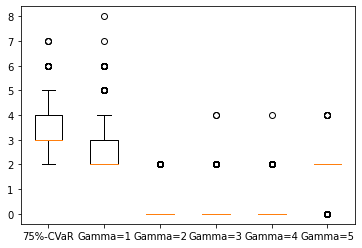

In [8]:
data_2 = np.random.multivariate_normal(mean, cov, size=size_)

OR_=np.argsort(data_2)
OR_=OR_+np.ones((size_,len(inst[2]))).astype(int)
OR=OR_.tolist()
penalty_cvar=[]
for k in OR:
    OR2=k
    a=0
    for j in range(inst[0]):
        for i in range(1,inst[1]):
            for i_ in range(i+1,inst[1]+1):
                if result[i-1][j]!=0 and result[i_-1][j]!=0:
                    if OR2.index(result[i-1][j])>OR2.index(result[i_-1][j]):
                        # print(j+1,height-i+1,O)
                        a+=1
                        # print("penalty!")
                            # print(i,i_,j+1,O)
                        break
    penalty_cvar.append(a)
penalty_cvar=np.sort(penalty_cvar)
penalty_cvar=penalty_cvar[round(0.75*size_):]
pcvar=[]
pcvar+=list(penalty_cvar)
data=(tuple(pcvar),)
l=["75%-CVaR"]
for g in range(1,6):
  prob=[]
  ship_num=len(inst[2])
  robust(ship_num,inst[0],inst[1],inst[2],g,size_,mean,cov)
  prob+=list(penalty_r)
#   print(prob)
  data+=(tuple(prob),)
  l.append("Gamma="+str(g))
  # print("data=",data)
import matplotlib.pyplot as plt
plt.boxplot(data,labels=l)
plt.show()
# plt.hist(penalty_cvar,bins=50)
# plt.show()

In [9]:
result

array([[0, 0, 0, 0, 0],
       [0, 0, 1, 4, 2],
       [1, 2, 3, 4, 5],
       [3, 5, 8, 6, 7],
       [8, 7, 9, 6, 9]])

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 92 rows, 96 columns and 420 nonzeros
Model fingerprint: 0x4674e4c6
Variable types: 0 continuous, 96 integer (96 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Found heuristic solution: objective 3.0000000
Presolve removed 0 rows and 8 columns
Presolve time: 0.00s
Presolved: 92 rows, 88 columns, 388 nonzeros
Found heuristic solution: objective 1.0000000
Variable types: 0 continuous, 88 integer (88 binary)

Root relaxation: objective 0.000000e+00, 23 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0       0.0000000    0.00000  0.00%     -    0s

Ex

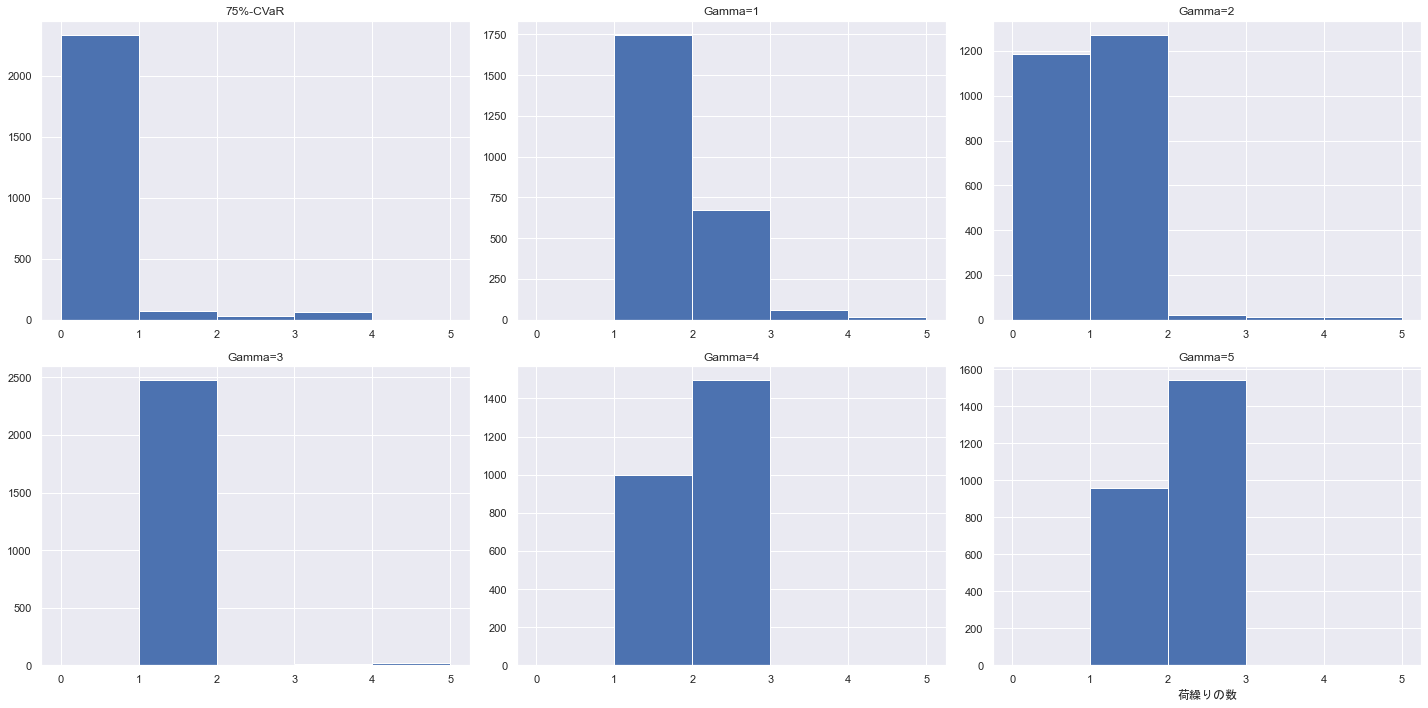

len= 2500


In [33]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,3,figsize=(20,10),tight_layout=True)
for g in range(1,6):
  prob=[]
  ship_num=len(inst[2])
  robust(ship_num,inst[0],inst[1],inst[2],g,size_,mean,cov)
  prob+=list(penalty_r)
  # print(prob)
  # data+=(tuple(prob),)
  # l.append("Gamma="+str(g))
  # print("data=",data)
# plt.boxplot(data,labels=l)
# plt.show()

  ax[int(g/3)][g%3].hist(prob,bins=5,range=(0,5))
  ax[int(g/3)][g%3].set_title("Gamma="+str(g))
  plt.xlabel("荷繰りの数",fontname="MS Gothic")
ax[0][0].hist(penalty_cvar,bins=5,range=(0,5))
ax[0][0].set_title("75%-CVaR")
plt.xlabel("荷繰りの数",fontname="MS Gothic")
plt.show()
print("len=",len(prob))

In [15]:
size=5000
size_=10000
beta=0.75
inst=[5,5,[3,3,1,1,2,2,3,2,3]]
pcvar=[]
import numpy as np
# mean=np.arange(1,ship_num+1)
mean=np.array([1,1.5,4,4.5,5,5.6,6,7,8])
covl=[1,1,1.5,1,1,1.5,1,1,1]
# a=list(a)
# a=random.sample(a,ship_num)
# mean=np.sort(a)
cov=np.zeros((len(inst[2]),len(inst[2])))
for i in range(len(inst[2])):
    for j in range(len(inst[2])):
        if i==j:
            cov[i][i]=covl[1]
for i in range(len(inst[2])):
    for j in range(len(inst[2])):
        if i!=j:
            cov[i][j]=0


OC=[]
EPS=0.1
a=0
UB=1000
LB=0
UB_k=[]
zk=[]
aaa=[]

model=CuttingPlaneAlgorithm(len(inst[2]),inst[0],inst[1],inst[2],size,size_,0.75,mean,cov,OC,zk,aaa)
model.solve()

OC= []
Set parameter LazyConstraints to value 1
Set parameter TimeLimit to value 3660
Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 236 rows, 105227 columns and 7634 nonzeros
Model fingerprint: 0x9c8f1757
Variable types: 105002 continuous, 225 integer (225 binary)
Coefficient statistics:
  Matrix range     [8e-04, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]
[[0 0 0 2 1]
 [2 0 0 4 5]
 [3 1 1 9 5]
 [7 2 6 9 7]
 [7 8 6 9 8]]
Len_dic= 1081
3499 3499
Presolve removed 30 rows and 10 columns
Presolve time: 0.26s
Presolved: 206 rows, 105217 columns, 7114 nonzeros
Variable types: 105002 continuous, 215 integer (215 binary)

Root simplex log...

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   2.000000e+01   0.000000e+00     48s
     124    0.0000000e+00   0.000000e+00   0.000000e+00 

In [16]:
b=model.get_optimal_val()
print(b)
x_opt,c_opt,alpha_opt,u_opt=model.get_optimal_sol()

result=model.get_result(x_opt)

None


TypeError: cannot unpack non-iterable NoneType object

In [17]:
print(result)

[[0 1 2 0 0]
 [0 1 2 0 4]
 [1 7 2 3 9]
 [5 7 6 8 9]
 [5 7 6 8 9]]


Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 210 rows, 200 columns and 955 nonzeros
Model fingerprint: 0xf45e56d4
Variable types: 0 continuous, 200 integer (200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 16.0000000
Presolve removed 0 rows and 15 columns
Presolve time: 0.02s
Presolved: 210 rows, 185 columns, 895 nonzeros
Found heuristic solution: objective 0.0000000
Variable types: 0 continuous, 185 integer (185 binary)

Explored 0 nodes (0 simplex iterations) in 0.07 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: 0 16 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
[[3 1 0 0 0]
 [5 1 6 0 2]
 [5 1 9 0 7]

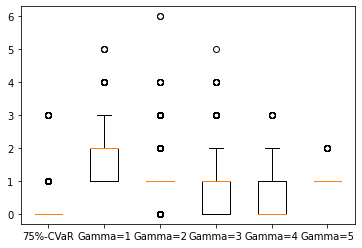

In [18]:
data_2 = np.random.multivariate_normal(mean, cov, size=size_)

OR_=np.argsort(data_2)
OR_=OR_+np.ones((size_,len(inst[2]))).astype(int)
OR=OR_.tolist()
penalty_cvar=[]
for k in OR:
    OR2=k
    a=0
    for j in range(inst[0]):
        for i in range(1,inst[1]):
            for i_ in range(i+1,inst[1]+1):
                if result[i-1][j]!=0 and result[i_-1][j]!=0:
                    if OR2.index(result[i-1][j])>OR2.index(result[i_-1][j]):
                        # print(j+1,height-i+1,O)
                        a+=1
                        # print("penalty!")
                            # print(i,i_,j+1,O)
                        break
    penalty_cvar.append(a)
penalty_cvar=np.sort(penalty_cvar)
penalty_cvar=penalty_cvar[round(0.75*size_):]
pcvar=[]
pcvar+=list(penalty_cvar)
data=(tuple(pcvar),)
l=["75%-CVaR"]
for g in range(1,6):
  prob=[]
  ship_num=len(inst[2])
  robust(ship_num,inst[0],inst[1],inst[2],g,size_,mean,cov)
  prob+=list(penalty_r)
#   print(prob)
  data+=(tuple(prob),)
  l.append("Gamma="+str(g))
  # print("data=",data)
import matplotlib.pyplot as plt
plt.boxplot(data,labels=l)
plt.show()
# plt.hist(penalty_cvar,bins=50)
# plt.show()

Gurobi Optimizer version 9.5.1 build v9.5.1rc2 (win64)
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads
Optimize a model with 210 rows, 200 columns and 955 nonzeros
Model fingerprint: 0xf45e56d4
Variable types: 0 continuous, 200 integer (200 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 5e+00]
Found heuristic solution: objective 16.0000000
Presolve removed 0 rows and 15 columns
Presolve time: 0.00s
Presolved: 210 rows, 185 columns, 895 nonzeros
Found heuristic solution: objective 0.0000000
Variable types: 0 continuous, 185 integer (185 binary)

Explored 0 nodes (0 simplex iterations) in 0.04 seconds (0.00 work units)
Thread count was 8 (of 8 available processors)

Solution count 2: 0 16 

Optimal solution found (tolerance 1.00e-04)
Best objective 0.000000000000e+00, best bound 0.000000000000e+00, gap 0.0000%
[[3 1 0 0 0]
 [5 1 6 0 2]
 [5 1 9 0 7]

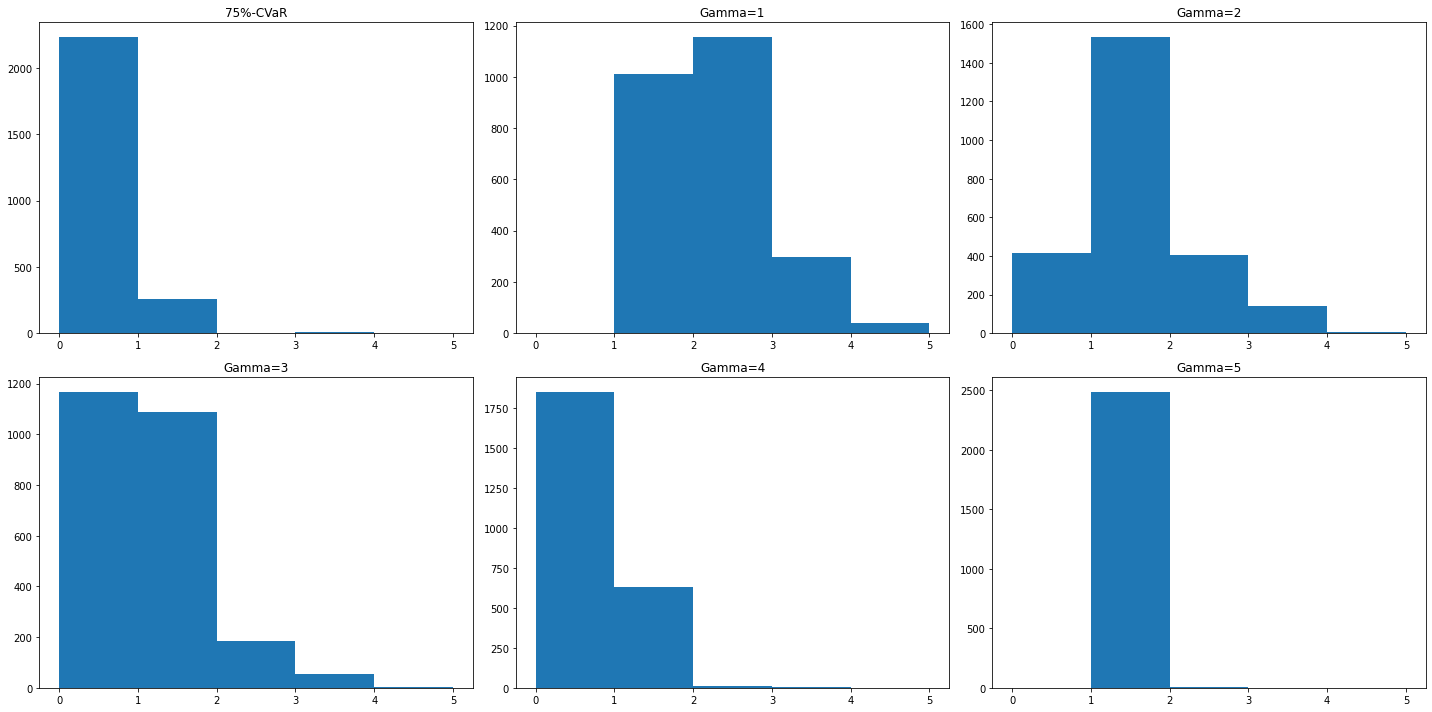

len= 2500


In [19]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2,3,figsize=(20,10),tight_layout=True)
for g in range(1,6):
  prob=[]
  ship_num=len(inst[2])
  robust(ship_num,inst[0],inst[1],inst[2],g,size_,mean,cov)
  prob+=list(penalty_r)
  # print(prob)
  # data+=(tuple(prob),)
  # l.append("Gamma="+str(g))
  # print("data=",data)
# plt.boxplot(data,labels=l)
# plt.show()

  ax[int(g/3)][g%3].hist(prob,bins=5,range=(0,5))
  ax[int(g/3)][g%3].set_title("Gamma="+str(g))
ax[0][0].hist(penalty_cvar,bins=5,range=(0,5))
ax[0][0].set_title("75%-CVaR")
plt.show()
print("len=",len(prob))

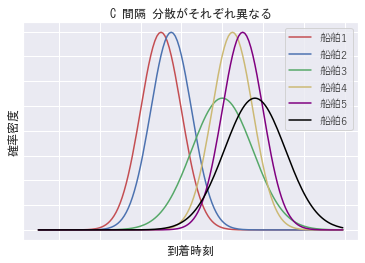

In [21]:
import numpy as np
from scipy.stats import norm
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

color=["r","b","g","y","purple","black"]

X=np.arange(-5,10,0.1)
y=[1,1,1.5,1,1,1.5]
for i,j in enumerate([1,1.5,4,4.5,5,5.6]):
  Y=norm.pdf(X,j,y[i])
  plt.plot(X,Y,color=color[i],label="船舶"+str(i+1))
plt.title("C 間隔 分散がそれぞれ異なる", fontname="MS Gothic")
plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
plt.xlabel('到着時刻', fontname="MS Gothic")
plt.ylabel('確率密度', fontname="MS Gothic")
plt.legend(prop={'family':'Yu Gothic'})
plt.show()


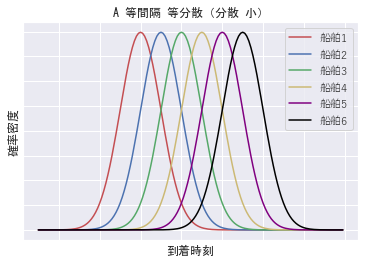

In [17]:
import numpy as np
from scipy.stats import norm
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

color=["r","b","g","y","purple","black"]

X=np.arange(-5,10,0.1)
y=[1 for i in range(6)]
for i,j in enumerate([i for i in range(6)]):
  Y=norm.pdf(X,j,y[i])
  plt.plot(X,Y,color=color[i],label="船舶"+str(i+1))
plt.title("A 等間隔 等分散（分散 小）", fontname="MS Gothic")
plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
plt.xlabel('到着時刻', fontname="MS Gothic")
plt.ylabel('確率密度', fontname="MS Gothic")
plt.legend(prop={'family':'Yu Gothic'})
plt.show()


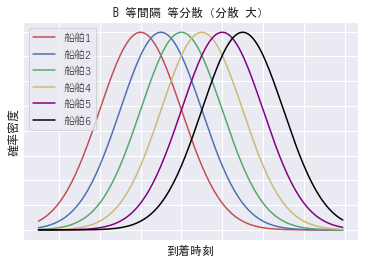

In [19]:
import numpy as np
from scipy.stats import norm
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

color=["r","b","g","y","purple","black"]

X=np.arange(-5,10,0.1)
y=[2 for i in range(6)]
for i,j in enumerate([i for i in range(6)]):
  Y=norm.pdf(X,j,y[i])
  plt.plot(X,Y,color=color[i],label="船舶"+str(i+1))
plt.title("B 等間隔 等分散（分散 大）", fontname="MS Gothic")
plt.tick_params(labelbottom=False, labelleft=False, labelright=False, labeltop=False)
plt.xlabel('到着時刻', fontname="MS Gothic")
plt.ylabel('確率密度', fontname="MS Gothic")
plt.legend(prop={'family':'Yu Gothic'})
plt.show()
